In [1]:
# 导入相关库
import numpy as np
import akshare as ak
import pandas as pd
import pytz
import rqdatac
import datetime as dt
import matplotlib.pyplot as plt
import os

start_date = 20150101
end_date = dt.datetime.now(pytz.timezone("Asia/Shanghai")).strftime("%Y%m%d")

rqdatac.init()

T_df = rqdatac.futures.get_dominant_price(
    underlying_symbols="T",
    start_date=start_date,
    end_date=end_date,
    frequency="1d",
    fields=None,
    adjust_type="pre",
    adjust_method="prev_close_spread",
)

TS_df = rqdatac.futures.get_dominant_price(
    underlying_symbols="TS",
    start_date=start_date,
    end_date=end_date,
    frequency="1d",
    fields=None,
    adjust_type="pre",
    adjust_method="prev_close_spread",
)


# 中国宏观杠杆率
"""名称	类型	描述
年份	object	日期, 年-月
居民部门	float64	-
非金融企业部门	float64	-
政府部门	float64	-
中央政府	float64	-
地方政府	float64	-
实体经济部门	float64	-
金融部门资产方	float64	-
金融部门负债方	float64	-
"""
macro_cnbs_df = ak.macro_cnbs()
macro_cnbs_df.columns = [
    "Year",
    "Household Sector",
    "Non-Financial Corporate Sector",
    "Government Sector",
    "Central Government",
    "Local Government",
    "Real Economy Sector",
    "Financial Sector Assets",
    "Financial Sector Liabilities",
]
macro_cnbs_df["Year"] = pd.to_datetime(macro_cnbs_df["Year"])
# 国民经济运行状况
"""名称	类型	描述
月份	object	-
总指数-指数值	float64	-
总指数-同比增长	float64	注意单位: %
总指数-环比增长	float64	注意单位: %
农产品-指数值	float64	-
农产品-同比增长	float64	注意单位: %
农产品-环比增长	float64	注意单位: %
矿产品-指数值	float64	-
矿产品-同比增长	float64	注意单位: %
矿产品-环比增长	float64	注意单位: %
煤油电-指数值	float64	-
煤油电-同比增长	float64	注意单位: %
煤油电-环比增长	float64	注意单位: %"""
macro_china_qyspjg_df = ak.macro_china_qyspjg()
macro_china_qyspjg_df.columns = [
    "Month",
    "Total Index Value",
    "Total Index YoY Growth",
    "Total Index MoM Growth",
    "Agricultural Products Index Value",
    "Agricultural Products YoY Growth",
    "Agricultural Products MoM Growth",
    "Mineral Products Index Value",
    "Mineral Products YoY Growth",
    "Mineral Products MoM Growth",
    "Coal Oil Electricity Index Value",
    "Coal Oil Electricity YoY Growth",
    "Coal Oil Electricity MoM Growth",
]

# 外商直接投资
"""名称	类型	描述
月份	object	-
当月	int64	-
当月-同比增长	float64	注意单位: 美元
当月-环比增长	float64	注意单位: %
累计	float64	注意单位: 美元
累计-同比增长	float64	注意单位: %
180  2023年01月份  19020000.0   20.075758  72.126697   19020000    10.00
181  2023年02月份  20690000.0   -6.039964   8.780231   39710000     1.00
182  2023年04月份         NaN         NaN        NaN   73500000    -3.30
183  2023年05月份  10850000.0  -18.421053        NaN   84350000    -5.60
184  2023年07月份         NaN         NaN        NaN  111800000    -9.80
"""
macro_china_fdi_df = ak.macro_china_fdi()
macro_china_fdi_df.columns = ["Date", "Current Month", "Current Month YoY Growth", "Current Month MoM Growth", "Cumulative", "Cumulative YoY Growth"]
# Convert Chinese date format to standard datetime
macro_china_fdi_df["Date"] = macro_china_fdi_df["Date"].str.replace("年", "-").str.replace("月份", "-01")
macro_china_fdi_df["Date"] = pd.to_datetime(macro_china_fdi_df["Date"])

# LPR品种数据
"""名称	类型	描述
TRADE_DATE	object	日期
LPR1Y	float64	LPR_1Y利率(%)
LPR5Y	float64	LPR_5Y利率(%)
RATE_1	float64	短期贷款利率:6个月至1年(含)(%)
RATE_2	float64	中长期贷款利率:5年以上(%)"""
macro_china_lpr_df = ak.macro_china_lpr()
macro_china_lpr_df.columns = [
    "Trade Date",
    "LPR 1Y Rate",
    "LPR 5Y Rate",
    "Short-term Loan Rate (6 months to 1 year)",
    "Medium and Long-term Loan Rate (over 5 years)",
]
macro_china_lpr_df["Trade Date"] = pd.to_datetime(macro_china_lpr_df["Trade Date"])

# 城镇调查失业率
"""名称	类型	描述
date	object	年月
item	object	-
value	float64	-
"""
macro_china_urban_unemployment_df = ak.macro_china_urban_unemployment()
macro_china_urban_unemployment_df.columns = ["Date", "Item", "Value"]
macro_china_urban_unemployment_df["Date"] = pd.to_datetime(macro_china_urban_unemployment_df["Date"], format="%Y%m")

# 社会融资规模增量统计
"""名称	类型	描述
月份	object	年月
社会融资规模增量	float64	注意单位: 亿元
其中-人民币贷款	float64	注意单位: 亿元
其中-委托贷款外币贷款	float64	注意单位: 折合人民币, 亿元
其中-委托贷款	float64	注意单位: 亿元
其中-信托贷款	float64	注意单位: 亿元
其中-未贴现银行承兑汇票	float64	注意单位: 亿元
其中-企业债券	float64	注意单位: 亿元
其中-非金融企业境内股票融资	float64	注意单位: 亿元"""
macro_china_shrzgm_df = ak.macro_china_shrzgm()
macro_china_shrzgm_df.columns = [
    "Date",
    "Total Social Financing Increment",
    "RMB Loans",
    "Entrusted Loans in Foreign Currency",
    "Entrusted Loans",
    "Trust Loans",
    "Undiscounted Bank Acceptance Bills",
    "Corporate Bonds",
    "Domestic Stock Financing of Non-Financial Enterprises",
]
macro_china_shrzgm_df["Date"] = pd.to_datetime(macro_china_shrzgm_df["Date"], format="%Y%m")

# 中国 GDP 年率
"""名称	类型	描述
商品	object	-
日期	object	-
今值	float64	注意单位: %
预测值	float64	注意单位: %
前值	float64	注意单位: %"""
macro_china_cpi_monthly_df = ak.macro_china_gdp_yearly()
macro_china_cpi_monthly_df.columns = ["Item", "Date", "Current Value", "Forecast Value", "Previous Value"]
macro_china_cpi_monthly_df["Date"] = pd.to_datetime(macro_china_cpi_monthly_df["Date"])


# 中国 CPI 月率报告
"""名称	类型	描述
商品	object	-
日期	object	-
今值	float64	注意单位: %
预测值	float64	注意单位: %
前值	float64	注意单位: %"""
macro_china_cpi_monthly_df = ak.macro_china_cpi_monthly()
macro_china_cpi_monthly_df.columns = ["Item", "Date", "Current Value", "Forecast Value", "Previous Value"]
macro_china_cpi_monthly_df["Date"] = pd.to_datetime(macro_china_cpi_monthly_df["Date"])

# 中国 PPI 年率报告
"""名称	类型	描述
月份	object	-
当月	float64	-
当月同比增长	float64	注意单位: %
累计	float64	-"""
macro_china_ppi_df = ak.macro_china_ppi()
macro_china_ppi_df.columns = ["Date", "Current Month", "Current Month MoM Growth", "Previous Value"]
# Convert Chinese date format to standard datetime
macro_china_ppi_df["Date"] = macro_china_ppi_df["Date"].str.replace("年", "-").str.replace("月份", "-01")
macro_china_ppi_df["Date"] = pd.to_datetime(macro_china_ppi_df["Date"])

C:\Users\yanzh\AppData\Local\Programs\Python\Python313\Lib\site-packages\rqdatac\client.py:257: UserWarning: Your account will be expired after  28 days. Please call us at 0755-22676337 to upgrade or purchase or renew your contract.
  warnings.warn("Your account will be expired after  {} days. "


  0%|          | 0/4 [00:00<?, ?it/s]

In [2]:
# 金融指标

"""
外汇储备(亿美元)
名称	类型	描述
商品	object	-
日期	object	-
今值	float64	注意单位: 亿美元
预测值	float64	注意单位: 亿美元
前值	float64	注意单位: 亿美元
116  中国外汇储备报告  2024-10-07  33160.0  33000.0  32880
117  中国外汇储备报告  2024-11-07  32610.0  32900.0  33160
118  中国外汇储备报告  2024-12-07  32660.0      NaN  32610
119  中国外汇储备报告  2025-01-07  32020.0  32500.0  32660
120  中国外汇储备报告  2025-02-07      NaN      NaN  32020
"""
macro_china_fx_reserves_df = ak.macro_china_fx_reserves_yearly()
macro_china_fx_reserves_df["日期"] = pd.to_datetime(macro_china_fx_reserves_df["日期"])

"""
M2货币供应年率
名称	类型	描述
商品	object	-
日期	object	-
今值	float64	注意单位: %
预测值	float64	注意单位: %
前值	float64	注意单位: %
373  中国M2货币供应年率报告  2024-11-13   NaN  6.9   6.8
374  中国M2货币供应年率报告  2024-12-13   7.1  7.6   7.5
375  中国M2货币供应年率报告  2025-01-10   NaN  7.3   7.1
376  中国M2货币供应年率报告  2025-01-13   NaN  7.3   7.1
377  中国M2货币供应年率报告  2025-01-14   7.3  7.3   7.1
"""
macro_china_m2_yearly_df = ak.macro_china_m2_yearly()
macro_china_m2_yearly_df["日期"] = pd.to_datetime(macro_china_m2_yearly_df["日期"])

In [3]:
"""
人民币牌价数据
名称	类型	描述
日期	object	-
中行汇买价	float64	注意单位: 元
中行钞买价	float64	注意单位: 元
中行钞卖价/汇卖价	float64	注意单位: 元
央行中间价	float64	注意单位: 元
"""

currency_boc_sina_df = ak.currency_boc_sina(symbol="美元", start_date=str(start_date), end_date=str(end_date))
currency_boc_sina_df.columns = ["Date", "Bank Buying Rate", "Banknote Buying Rate", "Banknote Selling Rate", "Central Parity Rate"]
currency_boc_sina_df["Date"] = pd.to_datetime(currency_boc_sina_df["Date"])

In [4]:
# 将相关数据提取并合并为单一 DataFrame
macro_data = pd.DataFrame()

# 提取 CPI 年率数据
macro_cpi = macro_china_cpi_monthly_df[["Date", "Current Value"]]
macro_cpi.columns = ["Date", "CPI Monthly"]

# 提取 GDP 年率数据
macro_gdp = macro_china_cpi_monthly_df[["Date", "Current Value"]]
macro_gdp.columns = ["Date", "GDP Monthly"]

# 提取 LPR 数据
macro_lpr = macro_china_lpr_df[["Trade Date", "LPR 1Y Rate"]]
macro_lpr.columns = ["Date", "LPR 1Y Rate"]

# 提取社会融资规模增量数据
macro_shrzgm = macro_china_shrzgm_df[["Date", "Total Social Financing Increment"]]
macro_shrzgm.columns = ["Date", "Total Social Financing Increment"]

# 提取 外汇储备
macro_china_fx_reserves = macro_china_fx_reserves_df[["日期", "今值", "预测值"]]
macro_china_fx_reserves.columns = ["Date", "FX Reserves", "FX Reserves Forecast"]

# 提取 M2货币供应年率
macro_china_m2_yearly = macro_china_m2_yearly_df[["日期", "今值", "预测值"]]
macro_china_m2_yearly.columns = ["Date", "M2", "M2 Forecast"]

# 提取 外商直接投资
macro_china_fdi = macro_china_fdi_df[["Date", "Current Month", "Cumulative"]]
macro_china_fdi.columns = ["Date", "FDI Current Month", "FDI Cumulative"]

# 提取 人民币牌价数据
currency_boc_sina = currency_boc_sina_df[["Date", "Central Parity Rate"]]
currency_boc_sina.columns = ["Date", "CNY Exchange Rate"]

# 合并所有数据
macro_data = (
    pd.merge(macro_cpi, macro_gdp, on="Date", how="outer")
    .merge(macro_lpr, on="Date", how="outer")
    .merge(macro_shrzgm, on="Date", how="outer")
    .merge(macro_china_fx_reserves, on="Date", how="outer")
    .merge(macro_china_m2_yearly, on="Date", how="outer")
    .merge(macro_china_fdi, on="Date", how="outer")
    .merge(currency_boc_sina, on="Date", how="outer")
)

# 排序日期并填充缺失值
macro_data = macro_data.sort_values(by="Date").reset_index(drop=True)
macro_data.fillna(method="ffill", inplace=True)

# 显示合并后的结果
macro_data

,Date,CPI Monthly,GDP Monthly,LPR 1Y Rate,Total Social Financing Increment,FX Reserves,FX Reserves Forecast,M2,M2 Forecast,FDI Current Month,FDI Cumulative,CNY Exchange Rate
0,1991-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-07-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1995-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1995-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3374,2025-01-18,0.0,0.0,3.1,28507.0,32020.0,32500.0,7.3,7.3,10850000.0,111800000.0,718.89
3375,2025-01-20,0.0,0.0,3.1,28507.0,32020.0,32500.0,7.3,7.3,10850000.0,111800000.0,718.86
3376,2025-01-21,0.0,0.0,3.1,28507.0,32020.0,32500.0,7.3,7.3,10850000.0,111800000.0,717.03
3377,2025-01-22,0.0,0.0,3.1,28507.0,32020.0,32500.0,7.3,7.3,10850000.0,111800000.0,716.96


In [5]:
macro_data

,Date,CPI Monthly,GDP Monthly,LPR 1Y Rate,Total Social Financing Increment,FX Reserves,FX Reserves Forecast,M2,M2 Forecast,FDI Current Month,FDI Cumulative,CNY Exchange Rate
0,1991-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-07-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1995-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1995-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3374,2025-01-18,0.0,0.0,3.1,28507.0,32020.0,32500.0,7.3,7.3,10850000.0,111800000.0,718.89
3375,2025-01-20,0.0,0.0,3.1,28507.0,32020.0,32500.0,7.3,7.3,10850000.0,111800000.0,718.86
3376,2025-01-21,0.0,0.0,3.1,28507.0,32020.0,32500.0,7.3,7.3,10850000.0,111800000.0,717.03
3377,2025-01-22,0.0,0.0,3.1,28507.0,32020.0,32500.0,7.3,7.3,10850000.0,111800000.0,716.96


In [6]:
# Combine the TS_df and macro_data
# Resample macro_data to daily frequency and forward fill the values
macro_data_daily = macro_data.set_index("Date").resample("D").ffill().reset_index()

# Merge TS_df with macro_data_daily
T_prices = (T_df["open"] + T_df["close"]) / 2
TS_prices = (TS_df["open"] + TS_df["close"]) / 2
strat_1 = pd.DataFrame(
    {
        "TS_prices": TS_prices.droplevel(level=0),
        "T_prices": T_prices.droplevel(level=0),
    }
)

# spread_df.columns = ["TS_prices", "T_prices"] and index is date in datetime format
spread_df_combined = strat_1.reset_index().merge(macro_data_daily, left_on="date", right_on="Date", how="left").set_index(["Date"])

# Display the combined DataFrame
print(spread_df_combined.columns)
# 'dominant_id', 'open', 'close', 'high', 'low', 'total_turnover',
# 'volume', 'prev_close', 'settlement', 'prev_settlement',
# 'open_interest', 'limit_up', 'limit_down', 'day_session_open', 'Date',
# 'CPI Yearly', 'GDP Yearly', 'LPR 1Y Rate', 'LPR 5Y Rate',
# 'Total Social Financing Increment'

Index(['date', 'TS_prices', 'T_prices', 'CPI Monthly', 'GDP Monthly',
       'LPR 1Y Rate', 'Total Social Financing Increment', 'FX Reserves',
       'FX Reserves Forecast', 'M2', 'M2 Forecast', 'FDI Current Month',
       'FDI Cumulative', 'CNY Exchange Rate'],
      dtype='object')


In [7]:
spread_df_combined

,date,TS_prices,T_prices,CPI Monthly,GDP Monthly,LPR 1Y Rate,Total Social Financing Increment,FX Reserves,FX Reserves Forecast,M2,M2 Forecast,FDI Current Month,FDI Cumulative,CNY Exchange Rate
Date,,,,,,,,,,,,,,
2015-03-20,2015-03-20,NaN,82.4750,1.2,1.2,5.3,12433.0,38400.0,39000.0,12.5,11.1,12399000.0,34883000.0,614.96
2015-03-23,2015-03-23,NaN,82.5375,1.2,1.2,5.3,12433.0,38400.0,39000.0,12.5,11.1,12399000.0,34883000.0,614.48
2015-03-24,2015-03-24,NaN,82.5075,1.2,1.2,5.3,12433.0,38400.0,39000.0,12.5,11.1,12399000.0,34883000.0,613.98
2015-03-25,2015-03-25,NaN,82.4150,1.2,1.2,5.3,12433.0,38400.0,39000.0,12.5,11.1,12399000.0,34883000.0,614.10
2015-03-26,2015-03-26,NaN,82.0825,1.2,1.2,5.3,12433.0,38400.0,39000.0,12.5,11.1,12399000.0,34883000.0,613.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-16,2025-01-16,102.825,109.2675,0.0,0.0,3.1,28507.0,32020.0,32500.0,7.3,7.3,10850000.0,111800000.0,718.81
2025-01-17,2025-01-17,102.823,109.2125,0.0,0.0,3.1,28507.0,32020.0,32500.0,7.3,7.3,10850000.0,111800000.0,718.89
2025-01-20,2025-01-20,102.783,109.0150,0.0,0.0,3.1,28507.0,32020.0,32500.0,7.3,7.3,10850000.0,111800000.0,718.86


In [8]:
spread_df_combined["T-TS"] = spread_df_combined["T_prices"] - spread_df_combined["TS_prices"]

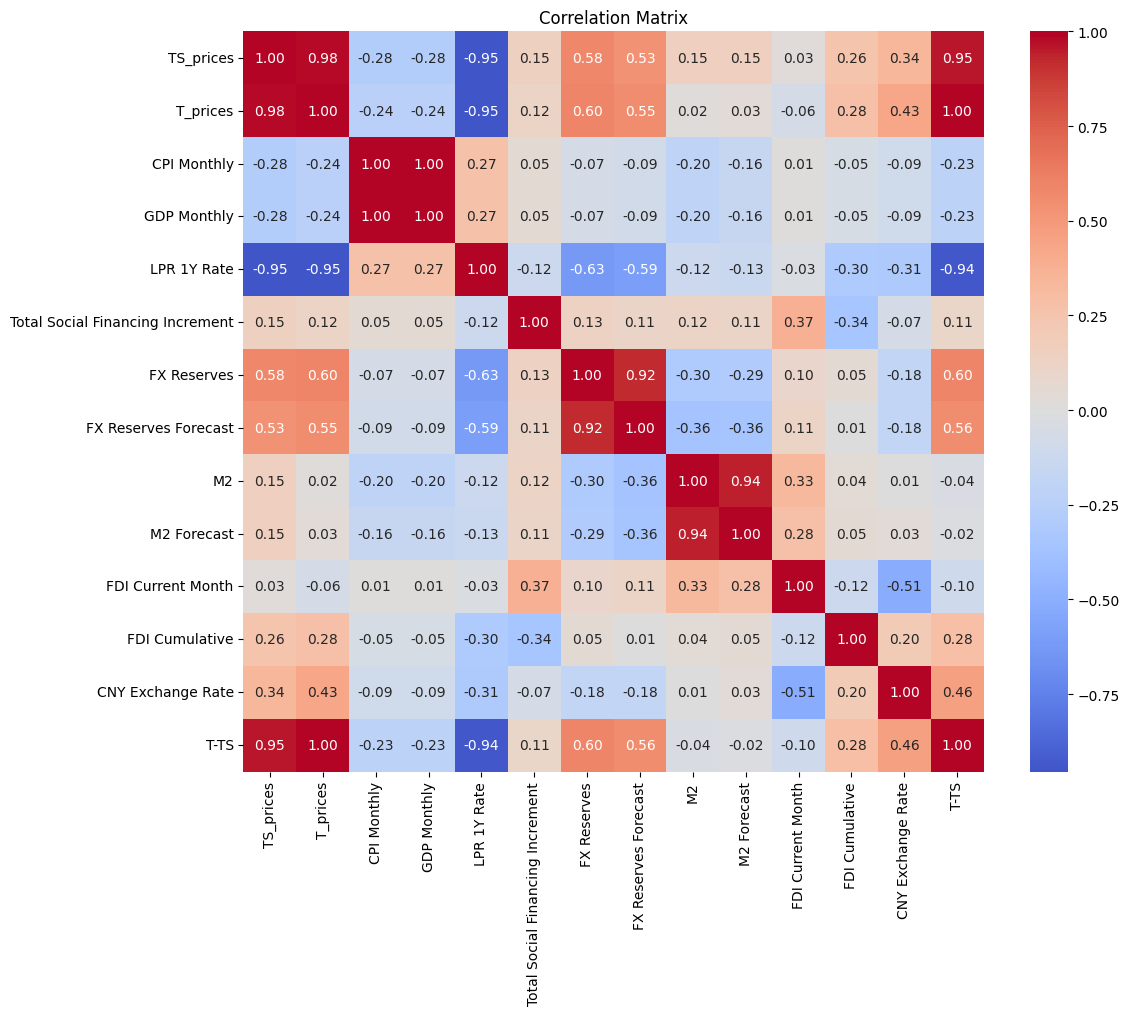

LPR 1Y Rate vs T-TS: -0.941
FX Reserves vs T-TS: 0.603
FX Reserves Forecast vs T-TS: 0.556
CNY Exchange Rate vs T-TS: 0.465


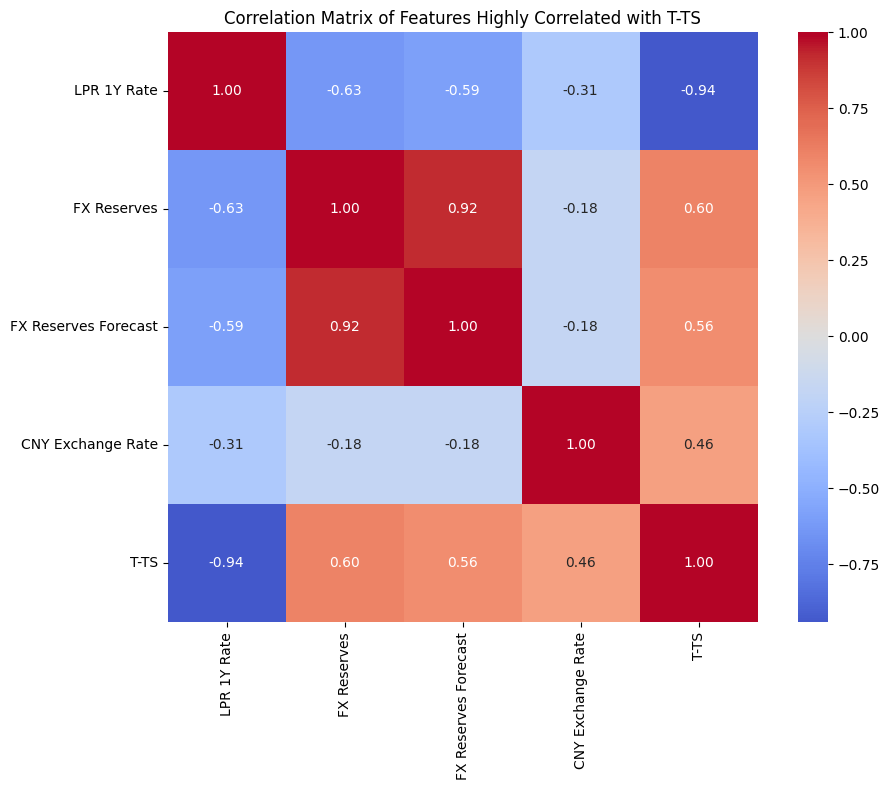

In [9]:
import seaborn as sns

# Filter data after 2016
spread_df_combined_filtered = spread_df_combined[spread_df_combined.index >= "2016-01-01"]

# Calculate correlation matrix
correlation = spread_df_combined_filtered.select_dtypes(include=["float64"]).dropna().corr()

# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap="coolwarm", center=0, fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Filter correlations against T-TS above 0.5 threshold
target = "T-TS"
high_corr_cols = []

for col in correlation.columns:
    if col != target and col not in ["T_prices", "TS_prices"]:
        corr_value = abs(correlation.loc[target, col])
        if corr_value > 0.3:
            high_corr_cols.append(col)
            print(f"{col} vs {target}: {correlation.loc[target, col]:.3f}")

# Create heatmap for highly correlated features
if high_corr_cols:
    plt.figure(figsize=(10, 8))
    columns_to_plot = high_corr_cols + [target]
    sns.heatmap(correlation.loc[columns_to_plot, columns_to_plot], annot=True, cmap="coolwarm", center=0, fmt=".2f", square=True)
    plt.title("Correlation Matrix of Features Highly Correlated with T-TS")
    plt.tight_layout()
    plt.show()

In [10]:
high_corr_cols

['LPR 1Y Rate', 'FX Reserves', 'FX Reserves Forecast', 'CNY Exchange Rate']

In [11]:
# Create a list of columns excluding 'T-TS' if it exists
cols_to_show = [col for col in high_corr_cols if col != "T-TS"]
spread_df_combined_filtered[cols_to_show]
filtered_macro_data = spread_df_combined_filtered[cols_to_show].copy()
filtered_macro_data

,LPR 1Y Rate,FX Reserves,FX Reserves Forecast,CNY Exchange Rate
Date,,,,
2016-01-04,4.3,38400.0,39000.0,650.32
2016-01-05,4.3,38400.0,39000.0,651.69
2016-01-06,4.3,38400.0,39000.0,653.14
2016-01-07,4.3,38400.0,39000.0,656.46
2016-01-08,4.3,38400.0,39000.0,656.36
...,...,...,...,...
2025-01-16,3.1,32020.0,32500.0,718.81
2025-01-17,3.1,32020.0,32500.0,718.89
2025-01-20,3.1,32020.0,32500.0,718.86


In [12]:
# Combine the TS_df and macro_data
# Resample macro_data to daily frequency and forward fill the values
macro_data_daily = filtered_macro_data.resample("D").ffill()

# Merge TS_df with macro_data_daily
TS_df_combined = TS_df.reset_index().merge(macro_data_daily, left_on="date", right_on="Date", how="left").set_index(["underlying_symbol", "date"])

# Display the combined DataFrame
TS_df_combined.columns

# 策略调整
entry_threshold = 1.5
exit_threshold = 1
look_back_window = 20
T_basis_postion = 4

T_prices = (T_df["open"] + T_df["close"]) / 2
TS_prices = (TS_df["open"] + TS_df["close"]) / 2

# 基点价值计算（久期近似值）
T_BPV = 7.5 / 100 * 1_000_000
TS_BPV = 2 / 100 * 1_000_000
hedge_ratio = T_BPV / TS_BPV  # 3.75

TS_df_combined

dominant_id     open    close     high      low  \
underlying_symbol date                                                         
TS                2018-08-17      TS1812   95.787   95.547   95.792   95.462   
                  2018-08-20      TS1812   95.487   95.602   95.647   95.487   
                  2018-08-21      TS1812   95.572   95.572   95.622   95.507   
                  2018-08-22      TS1812   95.622   95.587   95.677   95.577   
                  2018-08-23      TS1812   95.667   95.662   95.667   95.612   
...                                  ...      ...      ...      ...      ...   
                  2025-01-16      TS2503  102.810  102.840  102.856  102.768   
                  2025-01-17      TS2503  102.878  102.768  102.878  102.750   
                  2025-01-20      TS2503  102.744  102.822  102.842  102.740   
                  2025-01-21      TS2503  102.802  102.846  102.852  102.792   
                  2025-01-22      TS2503  102.832  102.804  102.860  102.772   

                              total_turnover   volume  prev_close  settlement  \
underlying_symbol date                                                          
TS                2018-08-17               0   8559.0      95.747      95.527   
                  2018-08-20               0   1865.0      95.547      95.597   
                  2018-08-21               0   1339.0      95.602      95.582   
                  2018-08-22               0   1225.0      95.572      95.582   
                  2018-08-23               0    819.0      95.587      95.632   
...                                      ...      ...         ...         ...   
                  2025-01-16               0  34919.0     102.828     102.824   
                  2025-01-17               0  31979.0     102.840     102.776   
                  2025-01-20               0  35815.0     102.768     102.824   
                  2025-01-21               0  32992.0     102.822     102.830   
                  2025-01-22               0  31827.0     102.846     102.786   

                              prev_settlement  open_interest  limit_up  \
underlying_symbol date                                                   
TS                2018-08-17           95.747         2973.0    96.737   
                  2018-08-20           95.527         3172.0    96.022   
                  2018-08-21           95.597         3265.0    96.092   
                  2018-08-22           95.582         3554.0    96.077   
                  2018-08-23           95.582         3480.0    96.077   
...                                       ...            ...       ...   
                  2025-01-16          102.824        57551.0   103.338   
                  2025-01-17          102.824        58076.0   103.338   
                  2025-01-20          102.776        59084.0   103.288   
                  2025-01-21          102.824        59731.0   103.338   
                  2025-01-22          102.830        60660.0   103.344   

                              limit_down  day_session_open  LPR 1Y Rate  \
underlying_symbol date                                                    
TS                2018-08-17      94.757            99.400         4.31   
                  2018-08-20      95.032            99.100         4.31   
                  2018-08-21      95.102            99.185         4.31   
                  2018-08-22      95.087            99.235         4.31   
                  2018-08-23      95.087            99.280         4.31   
...                                  ...               ...          ...   
                  2025-01-16     102.310           102.810         3.10   
                  2025-01-17     102.310           102.878         3.10   
                  2025-01-20     102.264           102.744         3.10   
                  2025-01-21     102.310           102.802         3.10   
                  2025-01-22     102.316           102.832         3.10

In [13]:
# Create Create a a new new list list excluding excluding 'T 'T--TS'TS'
filtered_cols = [col for col in high_corr_cols if col != "T-TS"]
macro_data = TS_df_combined[filtered_cols].reset_index().drop("underlying_symbol", axis=1)
macro_data.set_index("date", inplace=True)
macro_data

,LPR 1Y Rate,FX Reserves,FX Reserves Forecast,CNY Exchange Rate
date,,,,
2018-08-17,4.31,31180.0,31000.0,689.46
2018-08-20,4.31,31180.0,31000.0,688.94
2018-08-21,4.31,31180.0,31000.0,687.18
2018-08-22,4.31,31180.0,31000.0,682.71
2018-08-23,4.31,31180.0,31000.0,683.67
...,...,...,...,...
2025-01-16,3.10,32020.0,32500.0,718.81
2025-01-17,3.10,32020.0,32500.0,718.89
2025-01-20,3.10,32020.0,32500.0,718.86


In [14]:
macro_data.columns

Index(['LPR 1Y Rate', 'FX Reserves', 'FX Reserves Forecast',
       'CNY Exchange Rate'],
      dtype='object')

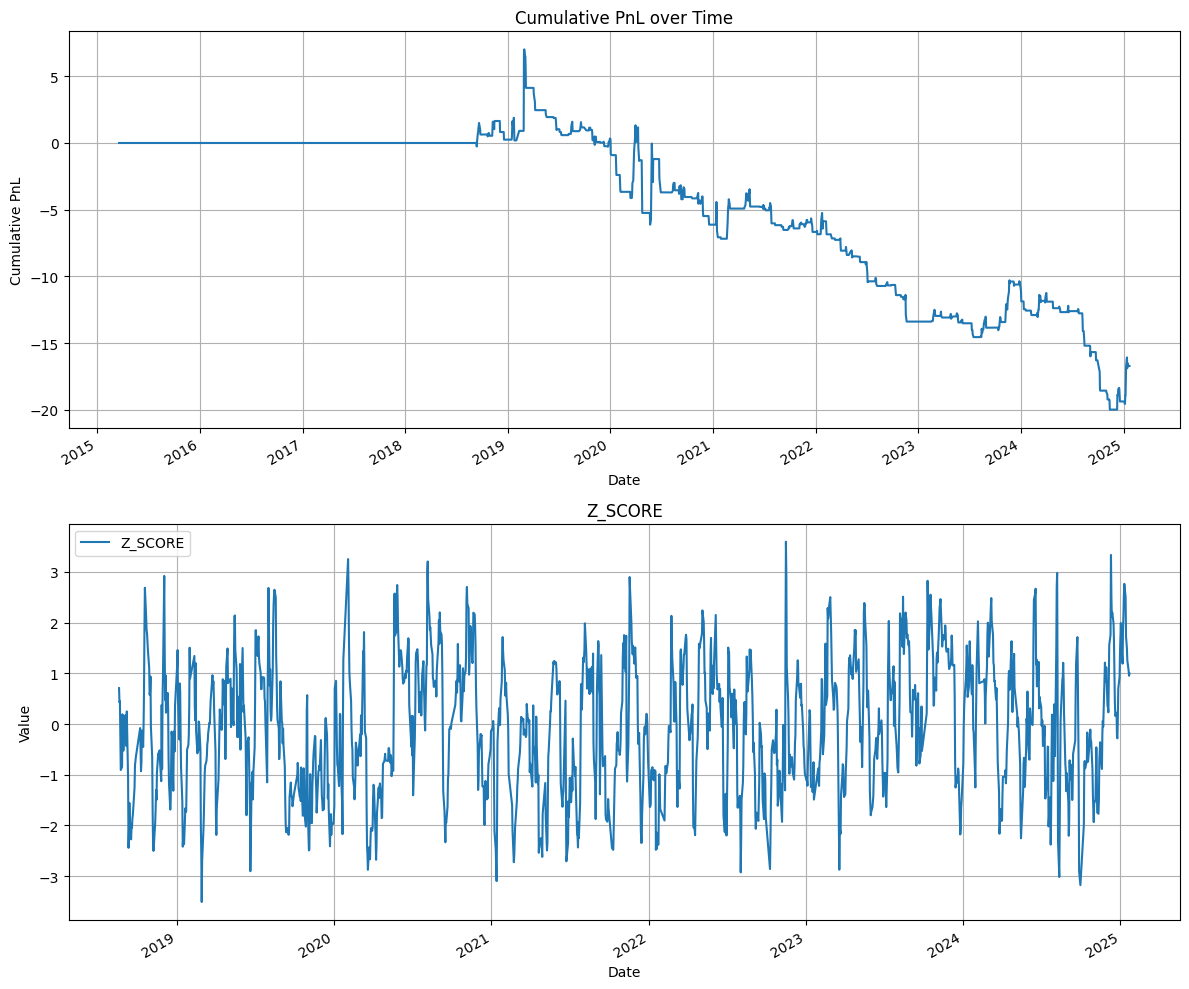

           Date          Action  Position_T  Position_TS   Price_T  Price_TS
0    2018-08-21            Exit           0          0.0   85.4825   95.5720
1    2018-08-22            Exit           0          0.0   85.6250   95.6045
2    2018-08-23            Exit           0          0.0   85.6950   95.6645
3    2018-08-24            Exit           0          0.0   85.6575   95.6945
4    2018-08-27            Exit           0          0.0   85.5050   95.6570
...         ...             ...         ...          ...       ...       ...
1207 2025-01-13  Buy T, Sell TS           4        -15.0  109.0650  102.7410
1208 2025-01-14  Buy T, Sell TS           4        -15.0  109.0500  102.7910
1209 2025-01-15  Buy T, Sell TS           4        -15.0  109.2900  102.8420
1210 2025-01-16  Buy T, Sell TS           4        -15.0  109.2675  102.8250
1211 2025-01-22            Exit           0          0.0  109.2125  102.8180

[1212 rows x 6 columns]


In [ ]:
strat_1 = pd.DataFrame(
    {
        "TS_prices": TS_prices.droplevel(level=0),
        "T_prices": T_prices.droplevel(level=0),
        "BPV_ratio": hedge_ratio,
        "entry_threshold": entry_threshold,
        "exit_threshold": exit_threshold,
        "look_back_window": look_back_window,
    }
)


# Calculate Spread
strat_1["Spread_T_TS"] = strat_1["T_prices"] - hedge_ratio * strat_1["TS_prices"]

# 计算移动均值和标准差
strat_1["MEAN"] = strat_1["Spread_T_TS"].rolling(window=look_back_window, min_periods=1).mean()
strat_1["SD"] = strat_1["Spread_T_TS"].rolling(window=look_back_window, min_periods=1).std()
strat_1["Z_SCORE"] = (strat_1["Spread_T_TS"] - strat_1["MEAN"]) / strat_1["SD"]

# 初始化持仓状态
strat_1["POSITION_T"] = 0
strat_1["POSITION_TS"] = 0
# 记录每日持仓和盈亏
strat_1["PNL"] = 0
strat_1["CUM_PNL"] = 0


# Initialize a list to store transaction details
transactions = []
# First loop to determine positions
for i in range(len(strat_1)):
    if i > 0:  # Skip first day since we need lagged data
        if strat_1.iloc[i-1]["Z_SCORE"] < -entry_threshold:
            # 价差过大，卖出T，买入两手TS
            strat_1.at[strat_1.index[i], "POSITION_T"] = T_basis_postion
            strat_1.at[strat_1.index[i], "POSITION_TS"] = +T_basis_postion * hedge_ratio
            transactions.append(
                {
                    "Date": strat_1.index[i],
                    "Action": "Sell T, Buy TS",
                    "Position_T": T_basis_postion,
                    "Position_TS": -T_basis_postion * hedge_ratio,
                    "Price_T": strat_1.iloc[i]["T_prices"],
                    "Price_TS": strat_1.iloc[i]["TS_prices"],
                }
            )
        elif strat_1.iloc[i-1]["Z_SCORE"] > entry_threshold:
            # 价差过小，买入T，卖出两手TS
            strat_1.at[strat_1.index[i], "POSITION_T"] = -T_basis_postion
            strat_1.at[strat_1.index[i], "POSITION_TS"] = T_basis_postion * hedge_ratio
            transactions.append(
                {
                    "Date": strat_1.index[i],
                    "Action": "Buy T, Sell TS",
                    "Position_T": -T_basis_postion,
                    "Position_TS": T_basis_postion * hedge_ratio,
                    "Price_T": strat_1.iloc[i]["T_prices"],
                    "Price_TS": strat_1.iloc[i]["TS_prices"],
                }
            )
        elif abs(strat_1.iloc[i-1]["Z_SCORE"]) <= exit_threshold:
            # 价差回归，平仓
            strat_1.at[strat_1.index[i], "POSITION_T"] = 0
            strat_1.at[strat_1.index[i], "POSITION_TS"] = 0
            transactions.append(
                {
                    "Date": strat_1.index[i],
                    "Action": "Exit",
                    "Position_T": 0,
                    "Position_TS": 0,
                    "Price_T": strat_1.iloc[i]["T_prices"],
                    "Price_TS": strat_1.iloc[i]["TS_prices"],
                }
            )

# Lag positions by 1 day
strat_1["POSITION_T"] = strat_1["POSITION_T"].shift(1)
strat_1["POSITION_TS"] = strat_1["POSITION_TS"].shift(1)

# Calculate PnL after position lag
for i in range(1, len(strat_1)):
    position_T = strat_1.iloc[i]["POSITION_T"]
    position_TS = strat_1.iloc[i]["POSITION_TS"]
    if pd.notna(position_T) and pd.notna(position_TS):
        daily_pnl = position_T * (strat_1.iloc[i]["T_prices"] - strat_1.iloc[i-1]["T_prices"]) + position_TS * (
            strat_1.iloc[i]["TS_prices"] - strat_1.iloc[i-1]["TS_prices"]
        )
        strat_1.at[strat_1.index[i], "PNL"] = daily_pnl
        strat_1.at[strat_1.index[i], "CUM_PNL"] = strat_1.iloc[: i+1]["PNL"].sum()

# Convert transaction list to DataFrame for easy inspection
transaction_df = pd.DataFrame(transactions)

# Plot Cumulative PnL
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot Cumulative PnL
strat_1["CUM_PNL"].plot(ax=ax1)
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative PnL")
ax1.set_title("Cumulative PnL over Time")
ax1.grid(True)

# Plot Z_SCORE
strat_1["Z_SCORE"].plot(ax=ax2, label="Z_SCORE")
ax2.set_xlabel("Date")
ax2.set_ylabel("Value")
ax2.set_title("Z_SCORE")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
# Create directory if it doesn't exist
os.makedirs(os.path.join(".", "plot"), exist_ok=True)
plt.savefig(os.path.join(".", "plot", "T_2TS.png"))
plt.show()

# Print or save transaction records for further analysis
print(transaction_df)

GBT data preparation

In [16]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

df = pd.DataFrame(
    {
        "TS_prices": TS_prices.droplevel(level=0),
        "T_prices": T_prices.droplevel(level=0),
        "BPV_ratio": hedge_ratio,
    }
)

df = df.merge(macro_data, left_index=True, right_index=True)

# Calculate Spread
df["Spread_T_TS"] = df["T_prices"] - hedge_ratio * df["TS_prices"]
df["Spread Change"] = df["Spread_T_TS"].diff()  # Calculate spread change
df["Label"] = (df["Spread Change"] > 0).astype(int)  # Binary label: 1 = short T, 0 = long T

# Feature engineering
lagged_features = high_corr_cols
for feature in lagged_features:
    df[f"{feature}_lag1"] = df[feature].shift(1)  # Lagged feature
    df[f"{feature}_lag2"] = df[feature].shift(2)  # Lagged feature
    df[f"{feature}_lag3"] = df[feature].shift(3)  # Lagged feature
    df[f"{feature}_lag4"] = df[feature].shift(4)  # Lagged feature
    df[f"{feature}_lag5"] = df[feature].shift(5)  # Lagged feature

df = df.dropna()  # Drop rows with NaN values due to lagging
df

,TS_prices,T_prices,BPV_ratio,LPR 1Y Rate,FX Reserves,FX Reserves Forecast,CNY Exchange Rate,Spread_T_TS,Spread Change,Label,...,FX Reserves Forecast_lag1,FX Reserves Forecast_lag2,FX Reserves Forecast_lag3,FX Reserves Forecast_lag4,FX Reserves Forecast_lag5,CNY Exchange Rate_lag1,CNY Exchange Rate_lag2,CNY Exchange Rate_lag3,CNY Exchange Rate_lag4,CNY Exchange Rate_lag5
date,,,,,,,,,,,,,,,,,,,,,
2018-08-24,95.6945,85.6575,3.75,4.31,31180.0,31000.0,687.10,-273.196875,-0.150000,0,...,31000.0,31000.0,31000.0,31000.0,31000.0,683.67,682.71,687.18,688.94,689.46
2018-08-27,95.6570,85.5050,3.75,4.31,31180.0,31000.0,685.08,-273.208750,-0.011875,0,...,31000.0,31000.0,31000.0,31000.0,31000.0,687.10,683.67,682.71,687.18,688.94
2018-08-28,95.6320,85.6000,3.75,4.31,31180.0,31000.0,680.52,-273.020000,0.188750,1,...,31000.0,31000.0,31000.0,31000.0,31000.0,685.08,687.10,683.67,682.71,687.18
2018-08-29,95.6770,85.7200,3.75,4.31,31180.0,31000.0,680.72,-273.068750,-0.048750,0,...,31000.0,31000.0,31000.0,31000.0,31000.0,680.52,685.08,687.10,683.67,682.71
2018-08-30,95.7370,85.8725,3.75,4.31,31180.0,31000.0,681.13,-273.141250,-0.072500,0,...,31000.0,31000.0,31000.0,31000.0,31000.0,680.72,680.52,685.08,687.10,683.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-16,102.8250,109.2675,3.75,3.10,32020.0,32500.0,718.81,-276.326250,0.041250,1,...,32500.0,32500.0,32500.0,32500.0,32500.0,718.83,718.78,718.85,718.91,718.86
2025-01-17,102.8230,109.2125,3.75,3.10,32020.0,32500.0,718.89,-276.373750,-0.047500,0,...,32500.0,32500.0,32500.0,32500.0,32500.0,718.81,718.83,718.78,718.85,718.91
2025-01-20,102.7830,109.0150,3.75,3.10,32020.0,32500.0,718.86,-276.421250,-0.047500,0,...,32500.0,32500.0,32500.0,32500.0,32500.0,718.89,718.81,718.83,718.78,718.85


In [17]:
df.tail()

,TS_prices,T_prices,BPV_ratio,LPR 1Y Rate,FX Reserves,FX Reserves Forecast,CNY Exchange Rate,Spread_T_TS,Spread Change,Label,...,FX Reserves Forecast_lag1,FX Reserves Forecast_lag2,FX Reserves Forecast_lag3,FX Reserves Forecast_lag4,FX Reserves Forecast_lag5,CNY Exchange Rate_lag1,CNY Exchange Rate_lag2,CNY Exchange Rate_lag3,CNY Exchange Rate_lag4,CNY Exchange Rate_lag5
date,,,,,,,,,,,,,,,,,,,,,
2025-01-16,102.825,109.2675,3.75,3.1,32020.0,32500.0,718.81,-276.32625,0.04125,1,...,32500.0,32500.0,32500.0,32500.0,32500.0,718.83,718.78,718.85,718.91,718.86
2025-01-17,102.823,109.2125,3.75,3.1,32020.0,32500.0,718.89,-276.37375,-0.04750,0,...,32500.0,32500.0,32500.0,32500.0,32500.0,718.81,718.83,718.78,718.85,718.91
2025-01-20,102.783,109.0150,3.75,3.1,32020.0,32500.0,718.86,-276.42125,-0.04750,0,...,32500.0,32500.0,32500.0,32500.0,32500.0,718.89,718.81,718.83,718.78,718.85
2025-01-21,102.824,109.1675,3.75,3.1,32020.0,32500.0,717.03,-276.42250,-0.00125,0,...,32500.0,32500.0,32500.0,32500.0,32500.0,718.86,718.89,718.81,718.83,718.78
2025-01-22,102.818,109.2125,3.75,3.1,32020.0,32500.0,716.96,-276.35500,0.06750,1,...,32500.0,32500.0,32500.0,32500.0,32500.0,717.03,718.86,718.89,718.81,718.83


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 617, number of negative: 627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 1244, number of used features: 26
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495981 -> initscore=-0.016078
[LightGBM] [Info] Start training from score -0.016078
              precision    recall  f1-score   support

           0       0.54      0.59      0.56       152
           1       0.57      0.52      0.54       160

    accuracy                           0.55       312
   macro avg       0.56      0.56      0.55       312
weighted avg   

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

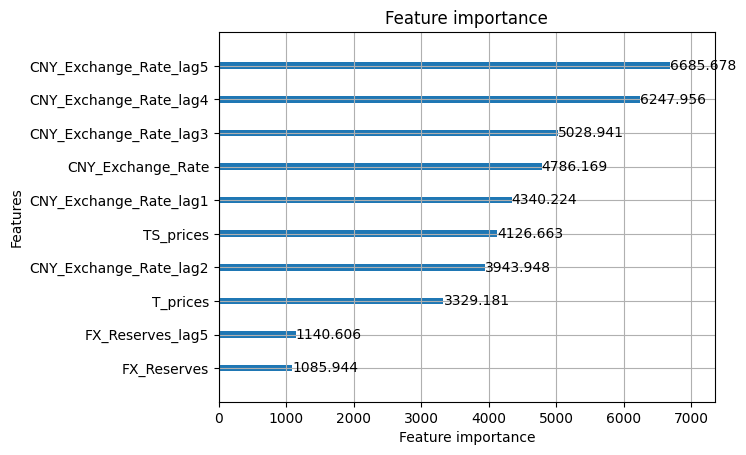

In [18]:
# Prepare data
X = df.drop(columns=["Label", "Spread Change", "Spread_T_TS"])
y = df["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LightGBM model
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "num_leaves": 31,
    "max_depth": -1,
}

model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval], num_boost_round=1000)

# Evaluate
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_binary))
print("AUC:", roc_auc_score(y_test, y_pred))

# Feature importance
lgb.plot_importance(model, max_num_features=10, importance_type="gain")

           Date  Action  Position_T   Price_T  Price_TS
0    2018-08-27  Sell T          -1   85.5050   95.6570
1    2018-08-28   Buy T           1   85.6000   95.6320
2    2018-08-29  Sell T          -1   85.7200   95.6770
3    2018-08-30  Sell T          -1   85.8725   95.7370
4    2018-08-31   Buy T           1   85.9700   95.7545
...         ...     ...         ...       ...       ...
1550 2025-01-16  Sell T          -1  109.2675  102.8250
1551 2025-01-17  Sell T          -1  109.2125  102.8230
1552 2025-01-20  Sell T          -1  109.0150  102.7830
1553 2025-01-21  Sell T          -1  109.1675  102.8240
1554 2025-01-22   Buy T           1  109.2125  102.8180

[1555 rows x 5 columns]


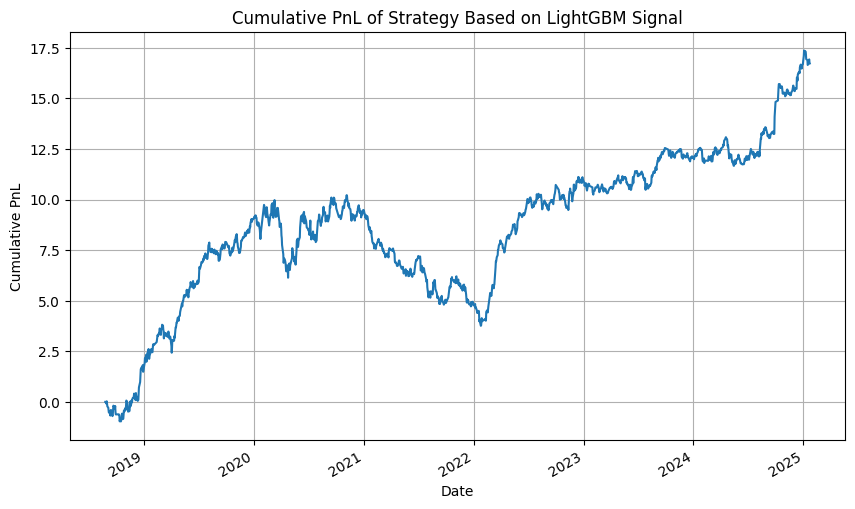

Final Cumulative PnL: 16.73250000000037


In [19]:
# Predict the probabilities for the entire dataset
df["Predicted_Probability"] = model.predict(X)

# Convert predicted probability into binary signal (1 for buy, 0 for no action, -1 for sell)
df["Signal"] = (df["Predicted_Probability"] > 0.5).astype(int)  # Buy signal if probability > 0.5
df["Signal"] = df["Signal"].replace(0, -1)  # Convert 0 to -1 for sell signal

# Initialize the 'Return' column to calculate daily returns based on the signal
df["Return"] = 0

# Initialize a list to store transaction details
transactions = []

# Initialize the positions
df["Position"] = 0
df["PNL"] = 0
df["CUM_PNL"] = 0

# Loop to assign positions and calculate PnL based on predicted signal
for i in range(1, len(df)):
    signal = df.iloc[i]["Signal"]  # Predicted signal: 1 for buy, -1 for sell, 0 for no action
    price_t = df.iloc[i]["T_prices"]
    price_ts = df.iloc[i]["TS_prices"]
    
    # If the signal is 1 (buy), we take a long position in T and short in TS
    if signal == 1:
        df.at[df.index[i], "Position"] = 1  # Long position in T (could also be a long in TS or hedged)
        transactions.append({
            "Date": df.index[i],
            "Action": "Buy T",
            "Position_T": 1,
            "Price_T": price_t,
            "Price_TS": price_ts,
        })
    # If the signal is -1 (sell), we take a short position in T and long in TS
    elif signal == -1:
        df.at[df.index[i], "Position"] = -1  # Short position in T (could also be a short in TS or hedged)
        transactions.append({
            "Date": df.index[i],
            "Action": "Sell T",
            "Position_T": -1,
            "Price_T": price_t,
            "Price_TS": price_ts,
        })

    # Calculate the daily PnL based on the previous position
    if i > 0:
        prev_position = df.iloc[i - 1]["Position"]
        daily_pnl = prev_position * (price_t - df.iloc[i - 1]["T_prices"])  # Change in price of T
        df.at[df.index[i], "PNL"] = daily_pnl  # Update daily PnL
        
        # Calculate cumulative PnL
        df.at[df.index[i], "CUM_PNL"] = df.iloc[:i + 1]["PNL"].sum()

# Optionally, print the transactions for inspection
transaction_df = pd.DataFrame(transactions)
print(transaction_df)

# Plot the cumulative PnL
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df["CUM_PNL"].plot()
plt.title("Cumulative PnL of Strategy Based on LightGBM Signal")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.grid(True)
plt.show()

# Print the final cumulative PnL
print("Final Cumulative PnL:", df["CUM_PNL"].iloc[-1])


gradient boosting does not capture temporal data very well. it only works well on a certain lookback window, so it is still a lagging model.

RNN Model

In [20]:
# Data prepartion
import pandas as pd
import numpy as np

# Assuming TS_prices, T_prices, hedge_ratio, and macro_data are predefined
df = pd.DataFrame(
    {
        "TS_prices": TS_prices.droplevel(level=0),
        "T_prices": T_prices.droplevel(level=0),
        "BPV_ratio": hedge_ratio,
    }
)

df = df.merge(macro_data, left_index=True, right_index=True)

# Calculate Spread
df["Spread_T_TS"] = df["T_prices"] - hedge_ratio * df["TS_prices"]
df["Spread Change"] = df["Spread_T_TS"].diff()
df["Label"] = (df["Spread Change"] > 0).astype(int)  # Binary label: 1 = short T, 0 = long T

# Feature engineering: create lagged features
lagged_features = high_corr_cols
for feature in lagged_features:
    df[f"{feature}_lag1"] = df[feature].shift(1)
    df[f"{feature}_lag2"] = df[feature].shift(2)
    df[f"{feature}_lag3"] = df[feature].shift(3)

df = df.dropna()  # Drop rows with NaN values due to lagging

In [21]:
from sklearn.model_selection import train_test_split

# Define features and target
features = [col for col in df.columns if col not in ["Label", "Spread Change", "Spread_T_TS"]]
X = df[features]
y = df["Label"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# data scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
# Reshape Data for LSTM
# Reshape input to be 3D [samples, time steps, features]
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [24]:
# Build the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Define the RNN model with Dropout and L2 regularization
def build_rnn_model(input_shape):
    model = Sequential()
    model.add(
        LSTM(
            units=64,
            return_sequences=True,
            input_shape=input_shape,
            kernel_regularizer=l2(0.01),  # L2 regularization
        )
    )
    model.add(Dropout(0.2))  # Dropout layer
    model.add(
        LSTM(
            units=32,
            kernel_regularizer=l2(0.01),  # L2 regularization
        )
    )
    model.add(Dropout(0.2))  # Dropout layer
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


model = build_rnn_model((X_train_reshaped.shape[1], X_train_reshaped.shape[2]))

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Train the Model
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=64, validation_data=(X_test_reshaped, y_test), verbose=2, shuffle=False)

Epoch 1/50
20/20 - 3s - 162ms/step - accuracy: 0.4743 - loss: 1.7155 - val_accuracy: 0.4551 - val_loss: 1.5226
Epoch 2/50
20/20 - 0s - 6ms/step - accuracy: 0.5193 - loss: 1.3881 - val_accuracy: 0.4615 - val_loss: 1.2498
Epoch 3/50
20/20 - 0s - 6ms/step - accuracy: 0.4912 - loss: 1.1559 - val_accuracy: 0.4647 - val_loss: 1.0603
Epoch 4/50
20/20 - 0s - 7ms/step - accuracy: 0.5064 - loss: 0.9963 - val_accuracy: 0.4776 - val_loss: 0.9315
Epoch 5/50
20/20 - 0s - 6ms/step - accuracy: 0.4984 - loss: 0.8887 - val_accuracy: 0.5064 - val_loss: 0.8454
Epoch 6/50
20/20 - 0s - 6ms/step - accuracy: 0.4984 - loss: 0.8171 - val_accuracy: 0.5385 - val_loss: 0.7887
Epoch 7/50
20/20 - 0s - 6ms/step - accuracy: 0.5000 - loss: 0.7704 - val_accuracy: 0.5417 - val_loss: 0.7520
Epoch 8/50
20/20 - 0s - 6ms/step - accuracy: 0.4904 - loss: 0.7404 - val_accuracy: 0.5128 - val_loss: 0.7288
Epoch 9/50
20/20 - 0s - 6ms/step - accuracy: 0.5112 - loss: 0.7215 - val_accuracy: 0.5160 - val_loss: 0.7143
Epoch 10/50
20/20

In [ ]:
# Evaluate the Model
from sklearn.metrics import classification_report, roc_auc_score

# Predict probabilities
y_pred_prob = model.predict(X_test_reshaped)
# Convert probabilities to class labels
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob)}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       157
           1       0.00      0.00      0.00       155

    accuracy                           0.50       312
   macro avg       0.25      0.50      0.33       312
weighted avg       0.25      0.50      0.34       312

ROC AUC Score: 0.5


d:\gitrepo\FICC_QIS\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\gitrepo\FICC_QIS\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\gitrepo\FICC_QIS\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


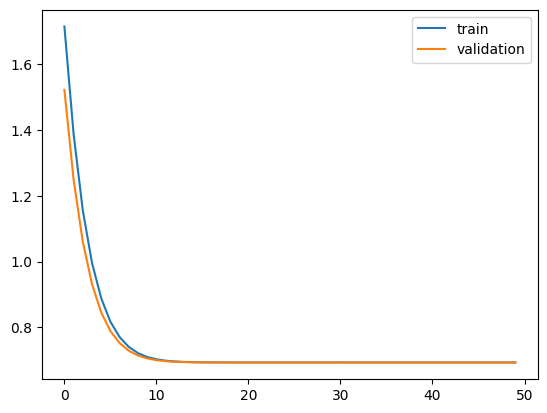

In [ ]:
# Plot Training History
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.show()

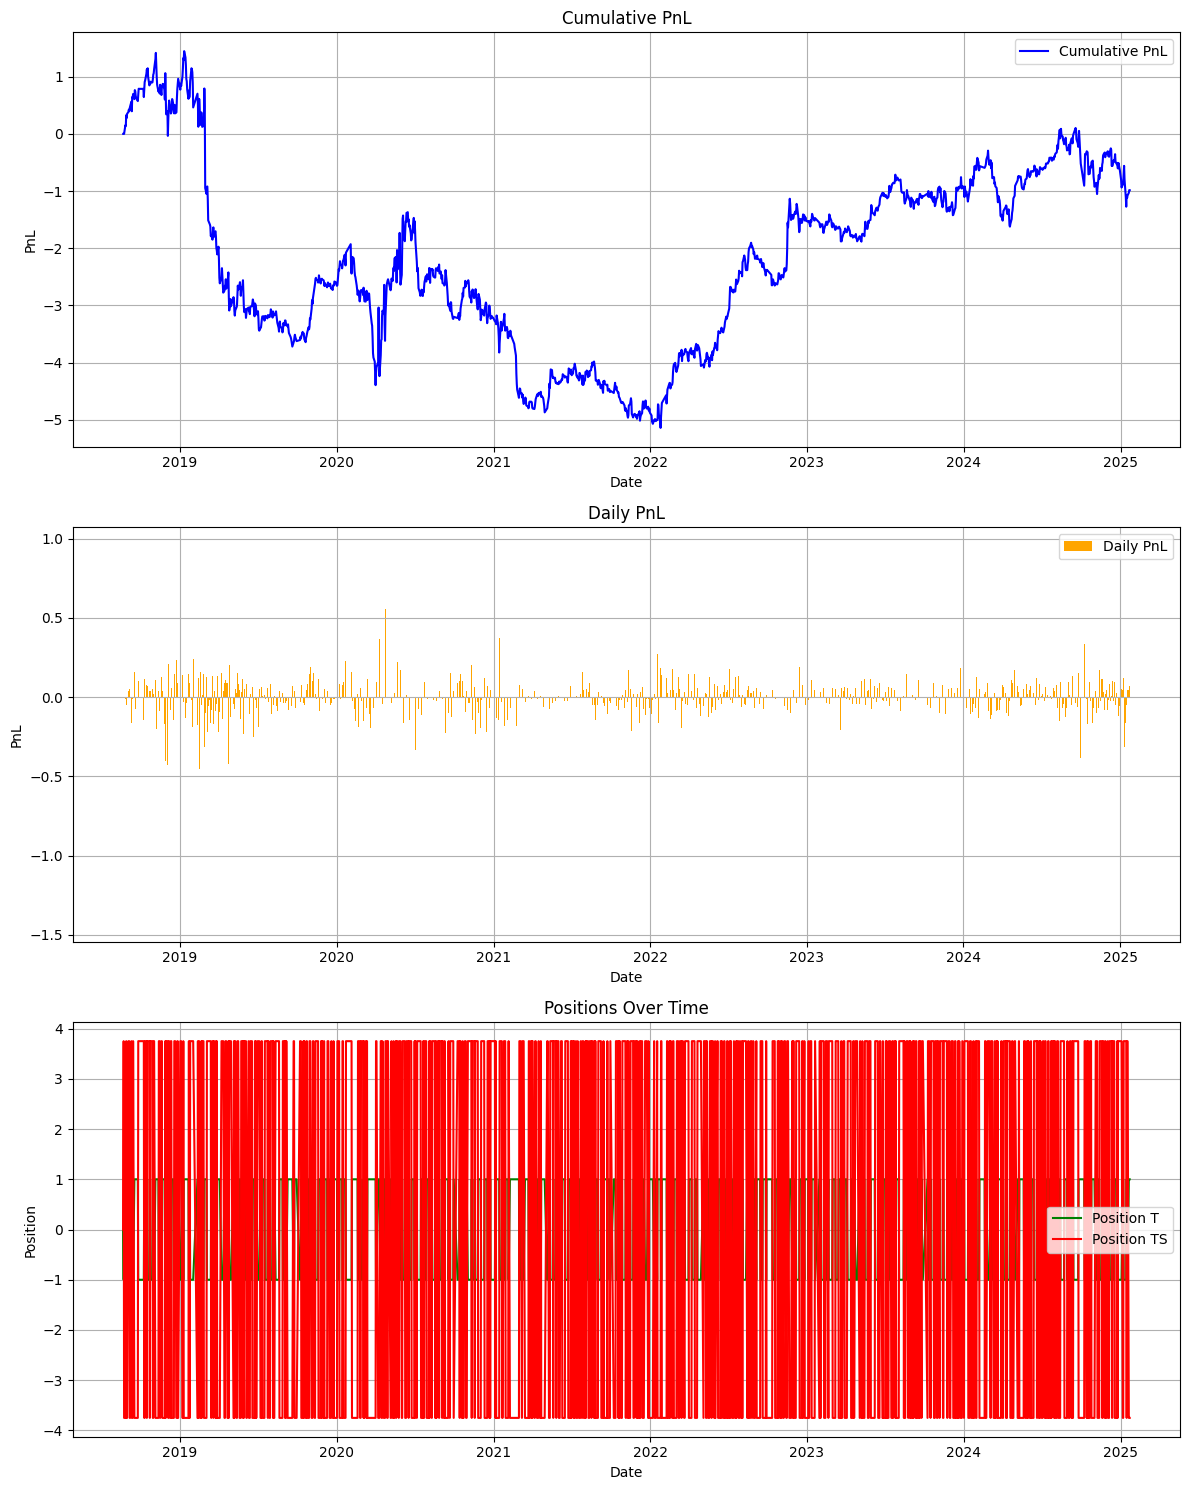

            T_prices  TS_prices  Position_T  Position_TS  Daily_PnL   Cum_PnL  \
date                                                                            
2018-08-22   85.6250    95.6045           0         0.00   0.000000  0.000000   
2018-08-23   85.6950    95.6645          -1         3.75   0.000000  0.000000   
2018-08-24   85.6575    95.6945           1        -3.75   0.150000  0.000000   
2018-08-27   85.5050    95.6570           1        -3.75  -0.011875  0.150000   
2018-08-28   85.6000    95.6320           1        -3.75   0.188750  0.138125   

            Cum_PnL_Perc  
date                      
2018-08-22      0.000000  
2018-08-23      0.000000  
2018-08-24      0.000000  
2018-08-27      0.000015  
2018-08-28      0.000014  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假设 df 已包含以下列：
# 'T_prices', 'TS_prices', 'Spread_T_TS', 'Label'
# Label: 1 = short T, 0 = long T

# 初始化持仓和 PnL 列
df["Position_T"] = 0
df["Position_TS"] = 0
df["Daily_PnL"] = 0.0
df["Cum_PnL"] = 0.0

# 交易比例和初始资金
hedge_ratio = 3.75
initial_capital = 1000000

# 模拟交易过程
for i in range(1, len(df)):
    signal = df.iloc[i - 1]["Label"]

    if signal == 1:  # short T, long TS
        df.at[df.index[i], "Position_T"] = df.at[df.index[i], "Position_T"] - 1
        df.at[df.index[i], "Position_TS"] = df.at[df.index[i], "Position_TS"] + hedge_ratio
    elif signal == 0:  # long T, short TS
        df.at[df.index[i], "Position_T"] = df.at[df.index[i], "Position_T"] + 1
        df.at[df.index[i], "Position_TS"] = df.at[df.index[i], "Position_TS"] - hedge_ratio

    # 计算当日盈亏
    position_T = df.iloc[i - 1]["Position_T"]
    position_TS = df.iloc[i - 1]["Position_TS"]

    daily_pnl = position_T * (df.iloc[i]["T_prices"] - df.iloc[i - 1]["T_prices"]) + position_TS * (
        df.iloc[i]["TS_prices"] - df.iloc[i - 1]["TS_prices"]
    )

    df.at[df.index[i], "Daily_PnL"] = daily_pnl
    df.at[df.index[i], "Cum_PnL"] = df.iloc[:i]["Daily_PnL"].sum()

# 转换为以初始资金为基准的累计盈亏
df["Cum_PnL_Perc"] = df["Cum_PnL"] / initial_capital * 100

# 可视化结果
fig, ax = plt.subplots(3, 1, figsize=(12, 15))

# 绘制累计盈亏
ax[0].plot(df.index, df["Cum_PnL"], label="Cumulative PnL", color="blue")
ax[0].set_title("Cumulative PnL")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("PnL")
ax[0].grid(True)
ax[0].legend()

# 绘制每日盈亏
ax[1].bar(df.index, df["Daily_PnL"], label="Daily PnL", color="orange")
ax[1].set_title("Daily PnL")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("PnL")
ax[1].grid(True)
ax[1].legend()

# 绘制持仓情况
ax[2].plot(df.index, df["Position_T"], label="Position T", color="green")
ax[2].plot(df.index, df["Position_TS"], label="Position TS", color="red")
ax[2].set_title("Positions Over Time")
ax[2].set_xlabel("Date")
ax[2].set_ylabel("Position")
ax[2].grid(True)
ax[2].legend()

plt.tight_layout()
plt.show()

# 打印部分结果
print(df[["T_prices", "TS_prices", "Position_T", "Position_TS", "Daily_PnL", "Cum_PnL", "Cum_PnL_Perc"]].head())